In [1]:
import os
import sys
from pathlib import Path

In [2]:
# Set up proper directory paths

project_path = Path().absolute().parent
src_path = project_path.joinpath("src")

# Ensure the paths are properly assigned
# If this assertion fails, change project_dir as needed to become the project directory
# If project_dir is correct, change the name in the assertion check
assert project_path.name == "project-athena", "Parent directory name assertion failed (check the path)"

In [3]:
# Add src_dir to module paths
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [4]:
import time

import numpy as np

In [5]:
from matplotlib import pyplot as plt

In [6]:
from attacks.attack import generate
from models.athena import ENSEMBLE_STRATEGY, Ensemble
from utils.data import subsampling
from utils.file import load_from_json, dump_to_json
from utils.metrics import error_rate, get_corrections
from utils.model import load_lenet, load_pool

Using TensorFlow backend.
C:\Users\covin\anaconda3\envs\athena_proj2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\covin\anaconda3\envs\athena_proj2\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\covin\anaconda3\envs\athena_proj2\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\covin\anaconda3\e

In [7]:
def generate_ae(model, data, labels, attack_configs, save=False, output_dir=None, device=None):
    """
    Generate adversarial examples for a model
    """
    
    print("Generating adversarial examples")
    
    ae_files = []
    
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)
    
    # For plotting
    img_rows, img_cols = data.shape[1], data.shape[2]

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # Generate attacks
    for attack_id in range(num_attacks):
        key = f"configs{attack_id}"
        
        data_adversarial = generate(model=model,
                                    data_loader=data_loader,
                                    attack_args=attack_configs[key],
                                    device=device)
        
        # Evaluate adversarial examples
        y_pred = model.predict(data_adversarial)
        y_pred = np.asarray([np.argmax(p) for p in y_pred])

        err = error_rate(y_pred=y_pred, y_true=labels)
        
        print(f">>> error rate: {err}")

        # Save adversarial examples
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            
            file_name = f"task1-{attack_configs[key]['description']}-{time.monotonic()}.npy"
            file_path = Path(output_dir).joinpath(file_name)
            np.save(file_path, data_adversarial)
            
            ae_files.append(file_name)
            
            print(f"Saved adversarial example to file [{file_path}]")
        
        print((attack_configs[key]['attack']))
        
        batch_size = min(data.shape[0], 2)
        fig = plt.figure(figsize=(1, batch_size), dpi=300)
        
        for i in range(batch_size):
            fig.add_subplot(1, batch_size, i + 1)
            plt.axis("off")
            plt.imshow(data_adversarial[i].reshape((img_rows, img_cols)), cmap='gray')
        
        
        plt.show()
        plt.savefig('results.pdf')
    
    print("Done generating adversarial examples")
    
    return ae_files

>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>>> Loading model [../models/cnn/model-mnist-cnn-distort_x.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_gaussian.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_sNp.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-filter_gaussian.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-geo_iradon.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-seg_gradient.h5]...
>>> Loaded 7 models.
Generating adversarial examples
>>> Generating PGD examples.


C:\Users\covin\anaconda3\envs\athena_proj2\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])
C:\Users\covin\anaconda3\envs\athena_proj2\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Users\covin\PycharmProjects\585 Project\project-athena\src\models\image_processor.py:856: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  interpolation=interpolation, circle=circle))
C:\Users\covin\PycharmProjects\585 Project\proje

>>> error rate: 0.018
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-PGD_eps0.05-106194.234.npy]
pgd


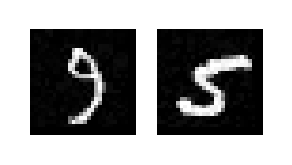

>>> Generating PGD examples.
>>> error rate: 0.132
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-PGD_eps0.2-106543.859.npy]
pgd


<Figure size 432x288 with 0 Axes>

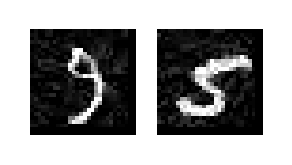

>>> Generating PGD examples.
>>> error rate: 0.91
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-PGD_eps0.5-106893.75.npy]
pgd


<Figure size 432x288 with 0 Axes>

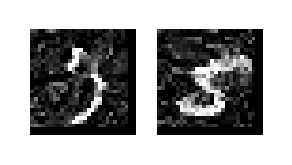

>>> Generating PGD examples.
>>> error rate: 0.974
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-PGD_eps0.7-107236.796.npy]
pgd


<Figure size 432x288 with 0 Axes>

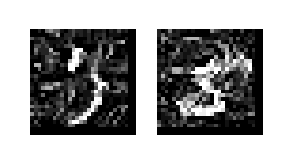

>>> Generating PGD examples.
>>> error rate: 0.978
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-PGD_eps-107612.703.npy]
pgd


<Figure size 432x288 with 0 Axes>

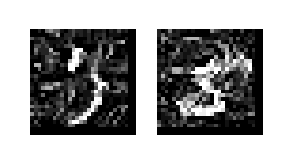

>>> Generating FGSM examples.
>>> error rate: 0.01
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-FGSM_eps0.01-107671.046.npy]
fgsm


<Figure size 432x288 with 0 Axes>

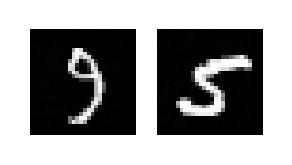

>>> Generating FGSM examples.
>>> error rate: 0.016
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-FGSM_eps0.05-107729.968.npy]
fgsm


<Figure size 432x288 with 0 Axes>

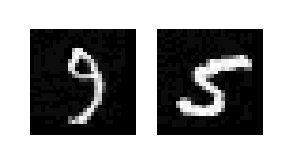

>>> Generating FGSM examples.
>>> error rate: 0.022
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-FGSM_eps0.1-107788.109.npy]
fgsm


<Figure size 432x288 with 0 Axes>

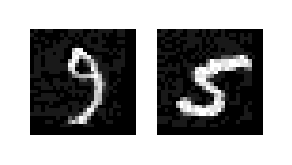

>>> Generating FGSM examples.
>>> error rate: 0.07
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-FGSM_eps0.2-107848.265.npy]
fgsm


<Figure size 432x288 with 0 Axes>

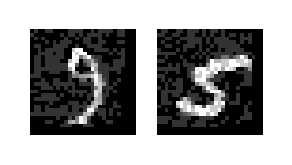

>>> Generating FGSM examples.
>>> error rate: 0.078
Saved adversarial example to file [C:\Users\covin\PycharmProjects\585 Project\project-athena\Task2\data\task1-FGSM_eps-107908.421.npy]
fgsm


<Figure size 432x288 with 0 Axes>

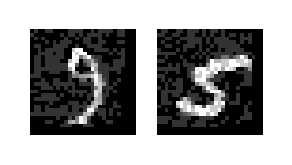

Done generating adversarial examples


['task1-PGD_eps0.05-106194.234.npy',
 'task1-PGD_eps0.2-106543.859.npy',
 'task1-PGD_eps0.5-106893.75.npy',
 'task1-PGD_eps0.7-107236.796.npy',
 'task1-PGD_eps-107612.703.npy',
 'task1-FGSM_eps0.01-107671.046.npy',
 'task1-FGSM_eps0.05-107729.968.npy',
 'task1-FGSM_eps0.1-107788.109.npy',
 'task1-FGSM_eps0.2-107848.265.npy',
 'task1-FGSM_eps-107908.421.npy']

<Figure size 432x288 with 0 Axes>

In [8]:
# Load data configs
file = project_path.joinpath("Task2/configs/data-mnist.json")
data_configs = load_from_json(file)

trans_configs = load_from_json(project_path.joinpath("Task2/configs/athena-mnist.json"))
model_configs = load_from_json(project_path.joinpath("Task2/configs/model-mnist.json"))

# In the context of the white-box threat model,
# we use the ensemble as adversary's target model.
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)

# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

attack_configs = load_from_json(project_path.joinpath("Task2/configs/attack-zk-mnist.json"))
output_path = project_path.joinpath("Task2/data")

generate_ae(model=target, data=data_bs,labels=labels, attack_configs=attack_configs,
            save=True, output_dir=output_path)

# Evaluating the generated adverserial example on the vanilla Athena.

In [ ]:
img_rows, img_cols = data_bs.shape[1], data_bs.shape[2]

pred_bs = target.predict(data_bs)
corrections = get_corrections(y_pred=pred_bs, y_true=labels)

results = {}

ae_files = data_configs.get('ae_files')

for file in ae_files:
    results[file] = {}
    ae_file = project_path.joinpath(data_configs['dir'], file)
    x_adversarial = np.load(ae_file)
    print(f">>> Running evaluations on [{ae_file}]")
    pred = ensemble.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    results[file] = err
    
result_file = project_path.joinpath("results/ae_evaluation_results.json")
dump_to_json(results, result_file)
print(f">>> Evaluations on all ae_files dumped to [{result_file}]")